In [1]:
import pandas as pd
import requests
import json
import gzip
import sys

from Bio import SeqIO
from enrichment_functions import * 
from draw_wordcloud import draw_word_cloud

import matplotlib.pyplot as plt

# Constants
URL = 'https://www.ebi.ac.uk/europepmc/annotations_api/annotationsByArticleIds'
PUBMED_IDS_PATH = '../../data/human_pubmed.tab.gz'
DOA_PATH = '../../data/uniprot_do.json'
DOID_PATH = '../../data/doid.obo'

## Mine and Parse DO

```Python
# { acc : disease ids list}
protein_to_do = map_protein_to_diseases(PUBMED_IDS_PATH, URL)

# Save result
json.dump(protein_to_do, '../../data/uniprot_do.json', indent = 4)

```

In [2]:
# Load DO on humans (DOA)
with open(DOA_PATH) as file:
    protein_to_do = json.load(file)

In [3]:
# Load DO ontology and parse
with open(DOID_PATH) as do_ontology:
    labels, ancestors, min_depth = parse_disease_ontology(do_ontology)

## Original dataset

In [4]:
# Read the original dataset (hits retrieved by our model)
with open("../../datasets/original.txt") as f:
    dataset = f.read().splitlines()
print("There are {} proteins in the original dataset".format(len(dataset)))

There are 92 proteins in the original dataset


In [5]:
# background datasets is the entire human proteom in SwissProt
human = SeqIO.parse('../../data/SwissProt_humans_reference_all.fasta','fasta')
background = []
for sequence in human:
    name = sequence.id # name is in the form sp|P46108|CRK_HUMAN
    background.append(name.split('|')[1])
    
print("There are {} proteins in the background dataset".format(len(background)))

There are 20367 proteins in the background dataset


In [6]:
# count the ancestors for each sequence of the dataset
dataset_count = count_ancestors(dataset, ancestors, protein_to_do)
background_count = count_ancestors(background, ancestors, protein_to_do)

In [7]:
# perform fisher exact test
result_fisher = fisher_test(dataset_count, background_count, min_depth, labels)

In [8]:
result_fisher.sort_values(by = "OddRatio", ascending=False, inplace=True)

In [9]:
result_fisher.head()

,OddRatio,p-value
5749,141.262327,1.401821e-02
6420,141.262327,1.401821e-02
0111512,141.262327,1.401821e-02
1884,101.164893,1.300295e-08
11702,94.235965,4.875143e-04


In [10]:
# add depth and description columns
result = add_depth_description(
    df = result_fisher,
    min_depth = min_depth, 
    labels = labels
)
result.head()

,OddRatio,p-value,depth,label
5749,141.262327,1.401821e-02,5,pulmonary valve disease
6420,141.262327,1.401821e-02,6,pulmonary valve stenosis
0111512,141.262327,1.401821e-02,7,metachondromatosis
1884,101.164893,1.300295e-08,6,viral hepatitis
11702,94.235965,4.875143e-04,6,dysgammaglobulinemia


In [11]:
# Bonferroni correction
# adjust threshold based on the numbe of tests
# http://www.biostathandbook.com/multiplecomparisons.html
alpha = 0.5
m = result_fisher.shape[0]
adjusted_threshold = alpha/m
print("Adjusted threshold: {}".format(adjusted_threshold))

Adjusted threshold: 0.001736111111111111


In [12]:
# filter by depth
filter_terms = (result_fisher["depth"] <= 6) & (result_fisher["p-value"] <= adjusted_threshold)

result_fisher[filter_terms].head()

,OddRatio,p-value,depth,label
1884,101.164893,1.300295e-08,6,viral hepatitis
11702,94.235965,4.875143e-04,6,dysgammaglobulinemia
6025,94.235965,4.875143e-04,5,selective immunoglobulin deficiency disease
12385,84.867413,1.894336e-05,5,shigellosis
7188,70.676645,7.278528e-04,6,autoimmune thyroiditis


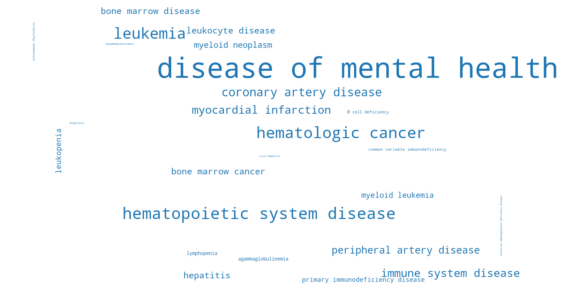

In [13]:
# Num of words to be drawn
N = 30

wc = draw_word_cloud(
    df = result_fisher[filter_terms],
    N = N,
    score = 'OddRatio',
    under_represented = True
)

# Plot
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

<br>
<br>
<br>
<br>
<br>
<br>

# Architectures Datasets

In [14]:
# file containing architectures datasets
ARCH_FILE_PATH = "../../datasets/architectures_datasets.json"

In [15]:
# read architecture
with open(ARCH_FILE_PATH) as f:
    arch_dataset = json.load(f)

In [16]:
# read the original dataset (hits retrieved by our model)
# it will be the background dataset
with open("../../datasets/original.txt") as f:
    bg_dataset = f.read().splitlines()

In [17]:
# count the anchestors for each sequence of the dataset
background_count = count_ancestors(bg_dataset, ancestors, protein_to_do)

# !!! ATTENZIONE !!!

## i p-value sono altissimi, se si filtra con bonferroni non esce nulla!
## se filtro con p-value < 0.05 poca roba appare, ma profonda
## vedi possibili filtraggi commentati

In [18]:
# create a list of df, in each one of them there is the results

# NB non credo che abbia troppo senso usare dataset composti da poche proteine
# filtro solo i dataset con più di 3
results = {}
filtered_results = {}

for key in arch_dataset:
    
    dataset = arch_dataset[key]
    
    if len(dataset) > 3:
        print(len(dataset))
    
        dataset_count = count_ancestors(dataset, ancestors, protein_to_do)

        # perform fisher exact test
        result_fisher = fisher_test(dataset_count, background_count, min_depth, labels)
        result_fisher.sort_values(by = "OddRatio", ascending=False, inplace=True)

        # add depth and description columns
        result = add_depth_description(
            df = result_fisher,
            min_depth = min_depth, 
            labels = labels )

        results[key] = result
        
        # Bonferroni correction
        # adjust threshold based on the numbe of tests
        # http://www.biostathandbook.com/multiplecomparisons.html
        alpha = 0.05
        m = result_fisher.shape[0]
        adjusted_threshold = alpha/m
            
        # filter by depth
        # filter_terms = (result_fisher["depth"] <= 3)
        
        # filter by p-value
        filter_terms = (result_fisher["p-value"] <= 0.05)
        
        # filter by adjusted p-value
        #filter_terms = (result_fisher["p-value"] <= adjusted_threshold)
        
        # filter by both
        # filter_terms = (result_fisher["depth"] <= 3) & (result_fisher["p-value"] <= adjusted_threshold)

        filtered_results[key] = result_fisher[filter_terms]
        
    
    

6
15
13
4
6


In [19]:
filtered_results.keys()

dict_keys(['PF00017,PF00018', 'PF00017', 'PF00017,PF00018,PF07714', 'PF00640,PF00017', 'PF07525,PF00017'])

In [20]:
filtered_results['PF00017']

,OddRatio,p-value,depth,label
11702,14.339623,0.023901,6,dysgammaglobulinemia
6025,14.339623,0.023901,5,selective immunoglobulin deficiency disease


(0, 4)
(2, 4)


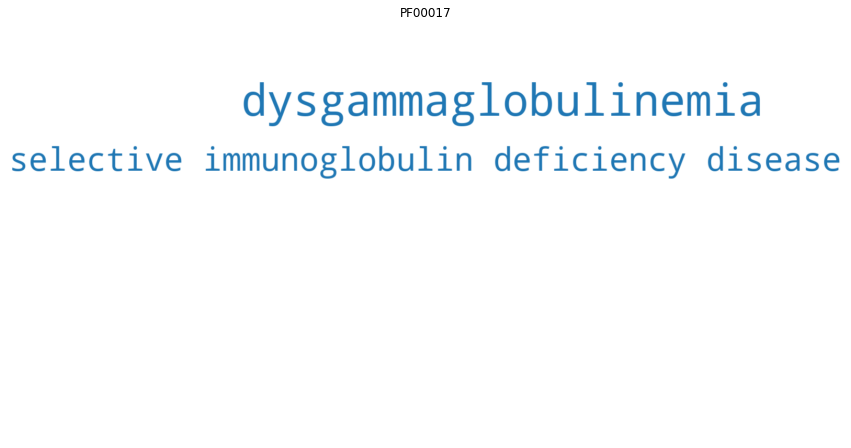

(0, 4)
(0, 4)
(1, 4)


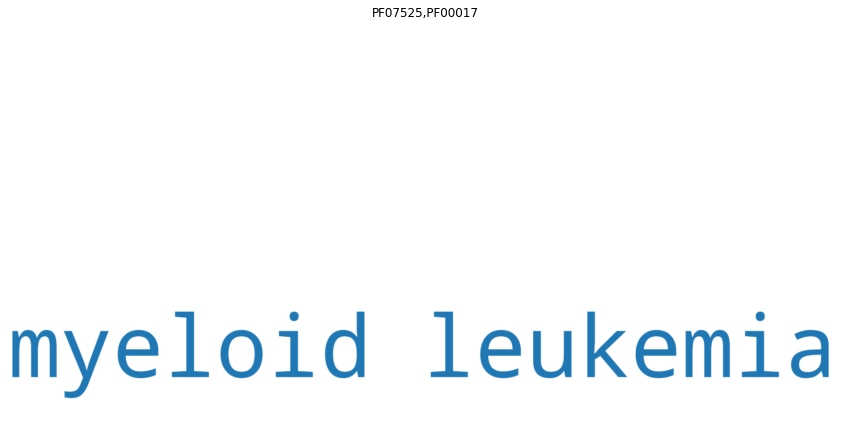

In [21]:
# draw wordcloud
for key in filtered_results:
    
    print(filtered_results[key].shape)
    
    if filtered_results[key].shape[0] > 0:
    
        # Num of words to be drawn
        N = 30

        wc = draw_word_cloud(
            df = filtered_results[key],
            N = N,
            score = 'OddRatio',
            scale = 2,
            under_represented=True
        )

        # Plot
        plt.figure(figsize=(15, 15))
        plt.title(key)
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.show()

<br>
<br>
<br>
<br>
<br>
<br>

# PDB Network dataset

In [22]:
# input dataset: pdb dataset
PDB_PATH = '../../datasets/pdb.cvs'

In [23]:
# read the pdb dataset (is a dataframe) 
dataset_df = pd.read_csv(PDB_PATH)

In [24]:
# get the list (unique) of proteins
dataset = dataset_df.sp_primary.unique()
print("There are {} proteins in the original dataset with a PDB \n \
      + other human proteins wich are found as other chains in the same PDB ".format(len(dataset)))

There are 110 proteins in the original dataset with a PDB 
       + other human proteins wich are found as other chains in the same PDB 


### create the background dataset

In [25]:
from pdb_network import *

In [26]:
list_human = getListHumans(PATH_REFERENCE_DB)

# Import original dataset
original_proteins = []
with open(PATH_ORIGINAL_DB) as file:
    for line in file:
        original_proteins.append(line.strip())
        
# Import pdb - uniprot relation file
pdb_rel = pd.read_csv(PATH_PDB_UNIPROT_REL, sep = '\t', header = 1)
pdb_rel.columns = list(map(lambda x: x.lower(), pdb_rel.columns.values))

# Create background dataframe, all PDB proteins in swissprot
pdb_bg_df = pdb_rel.loc[pdb_rel.sp_primary.isin(list_human),['pdb','sp_primary','chain','sp_beg','sp_end']].copy()

There are 20367 human proteins in SwissProt


In [27]:
# get the list (unique) of proteins in swissprot with a PDB
bg_dataset = pdb_bg_df.sp_primary.unique()
print("There are {} human PDB proteins in Swissprot".format(len(bg_dataset)))

There are 6756 human PDB proteins in Swissprot


### Calculate enrichment

In [28]:
# count the anchestors for each sequence of the dataset
dataset_count = count_ancestors(dataset, ancestors, protein_to_do)
background_count = count_ancestors(bg_dataset, ancestors, protein_to_do)

In [29]:
# perform fisher exact test
result_fisher = fisher_test(dataset_count, background_count, min_depth, labels)

In [30]:
result_fisher.sort_values(by = "OddRatio", ascending=False, inplace=True)

In [31]:
# add depth and description columns
result = add_depth_description(
    df = result_fisher,
    min_depth = min_depth, 
    labels = labels
)
result.head()

,OddRatio,p-value,depth,label
6420,38.727753,0.049727,6,pulmonary valve stenosis
874,38.727753,0.049727,6,bacterial pneumonia
0111512,38.727753,0.049727,7,metachondromatosis
118,38.727753,0.049727,4,pericardial effusion
3263,38.727753,0.049727,5,piebaldism


In [32]:
# Bonferroni correction
# adjust threshold based on the numbe of tests
# http://www.biostathandbook.com/multiplecomparisons.html
alpha = 0.05
m = result_fisher.shape[0]
adjusted_threshold = alpha/m
print("Adjusted threshold: {}".format(adjusted_threshold))

Adjusted threshold: 0.00011363636363636364


In [33]:
# filter by depth
filter_terms = (result_fisher["depth"] <= 6) & (result_fisher["p-value"] <= adjusted_threshold)
#filter_terms = result_fisher["p-value"] <= adjusted_threshold
result_fisher[filter_terms].head()

,OddRatio,p-value,depth,label
1884,32.320305,0.000004,6,viral hepatitis
12385,31.016082,0.000046,5,shigellosis
614,12.931495,0.000023,5,lymphopenia
2115,9.701342,0.000023,4,B cell deficiency
0070004,4.800577,0.000046,6,myeloid neoplasm


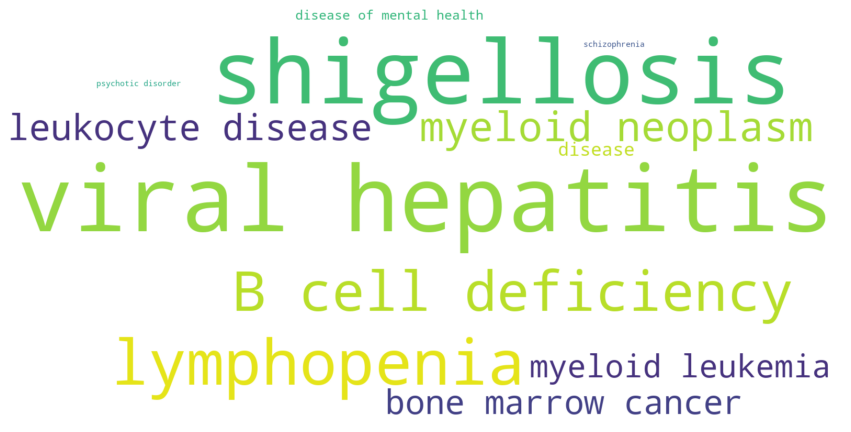

In [34]:
# Num of words to be drawn
N = 30

wc = draw_word_cloud(
    df = result_fisher[filter_terms],
    N = N,
    score = 'OddRatio',
    scale = 2,
    under_represented=False
)

# Plot
plt.figure(figsize=(15, 15))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

<br>
<br>
<br>
<br>
<br>
<br>

# STRING Dataset

In [35]:
# read the STRING dataset (proteins of the original dataset + all direct STRING interactors)
with open("../../datasets/string.txt") as f:
    dataset = f.read().splitlines()
print("There are {} proteins in the STRING dataset".format(len(dataset)))

There are 441 proteins in the STRING dataset


### Create background dataset

In [36]:
import requests

URL = "https://www.uniprot.org"

# All human proteins available in STRING and Swissprot
query = "database:(type:string) AND reviewed:yes AND organism:\"Homo sapiens (Human) [9606]\"&format=list"
r = requests.get("{}/uniprot/?query={}".format(URL, query))

In [37]:
bg_dataset = r.text.strip().split("\n")
print("There are {} human proteins available in STRING and Swissprot".format(len(bg_dataset)))

There are 18561 human proteins available in STRING and Swissprot


### Calculate enrichment

In [38]:
# count the anchestors for each sequence of the dataset
dataset_count = count_ancestors(dataset, ancestors, protein_to_do)
background_count = count_ancestors(bg_dataset, ancestors, protein_to_do)

In [39]:
# perform fisher exact test
result_fisher = fisher_test(dataset_count, background_count, min_depth, labels)

In [40]:
result_fisher.sort_values(by = "OddRatio", ascending=False, inplace=True)

In [41]:
# add depth and description columns
result = add_depth_description(
    df = result_fisher,
    min_depth = min_depth, 
    labels = labels
)
result.head()

,OddRatio,p-value,depth,label
0111337,24.863864,0.008517,5,Jackson-Weiss syndrome
9253,24.860948,0.075850,5,gastrointestinal stromal tumor
2059,24.860948,0.075850,4,vulvar disease
14472,24.860948,0.075850,5,hantavirus pulmonary syndrome
14115,24.860948,0.075850,4,toxic shock syndrome


In [42]:
# Bonferroni correction
# adjust threshold based on the numbe of tests
# http://www.biostathandbook.com/multiplecomparisons.html
alpha = 0.05
m = result_fisher.shape[0]
adjusted_threshold = alpha/m
print("Adjusted threshold: {}".format(adjusted_threshold))

Adjusted threshold: 7.225433526011561e-05


In [43]:
# filter by depth
filter_terms = (result_fisher["depth"] <= 6) & (result_fisher["p-value"] <= adjusted_threshold)
#filter_terms = result_fisher["p-value"] <= adjusted_threshold
result_fisher[filter_terms].head()

,OddRatio,p-value,depth,label
1884,17.765980,5.445043e-05,6,viral hepatitis
3490,12.441597,4.785573e-07,3,Noonan syndrome
5241,12.437401,4.144679e-05,6,hemangioblastoma
350,11.480621,5.858720e-05,4,mastocytosis
2115,8.295816,6.745795e-07,4,B cell deficiency


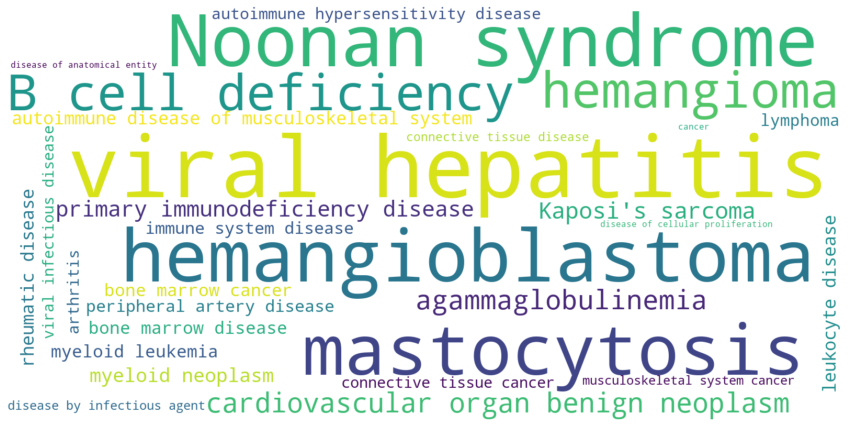

In [44]:
# Num of words to be drawn
N = 30

wc = draw_word_cloud(
    df = result_fisher[filter_terms],
    N = N,
    score = 'OddRatio',
    scale = 2,
    under_represented=False
)

# Plot
plt.figure(figsize=(15, 15))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()